In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA

In [3]:
df = pd.read_excel("Online Retail.xlsx")

# Menampilkan beberapa baris pertama
print(df.head())

  InvoiceNo StockCode                          Description  Quantity  \
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1    536365     71053                  WHITE METAL LANTERN         6   
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   

          InvoiceDate  UnitPrice  CustomerID         Country  
0 2010-12-01 08:26:00       2.55     17850.0  United Kingdom  
1 2010-12-01 08:26:00       3.39     17850.0  United Kingdom  
2 2010-12-01 08:26:00       2.75     17850.0  United Kingdom  
3 2010-12-01 08:26:00       3.39     17850.0  United Kingdom  
4 2010-12-01 08:26:00       3.39     17850.0  United Kingdom  


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB
None
            Quantity                    InvoiceDate      UnitPrice  \
count  541909.000000                         541909  541909.000000   
mean        9.552250  2011-07-04 13:34:57.156386048       4.611114   
min    -80995.000000            2010-12-01 08:26:00  -11062.060000   
25%         1.000000   

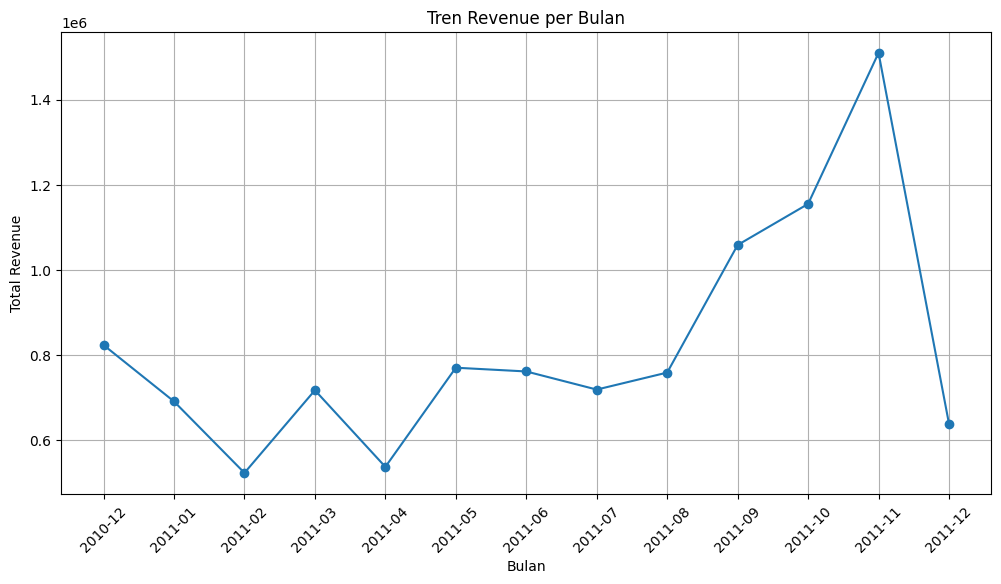

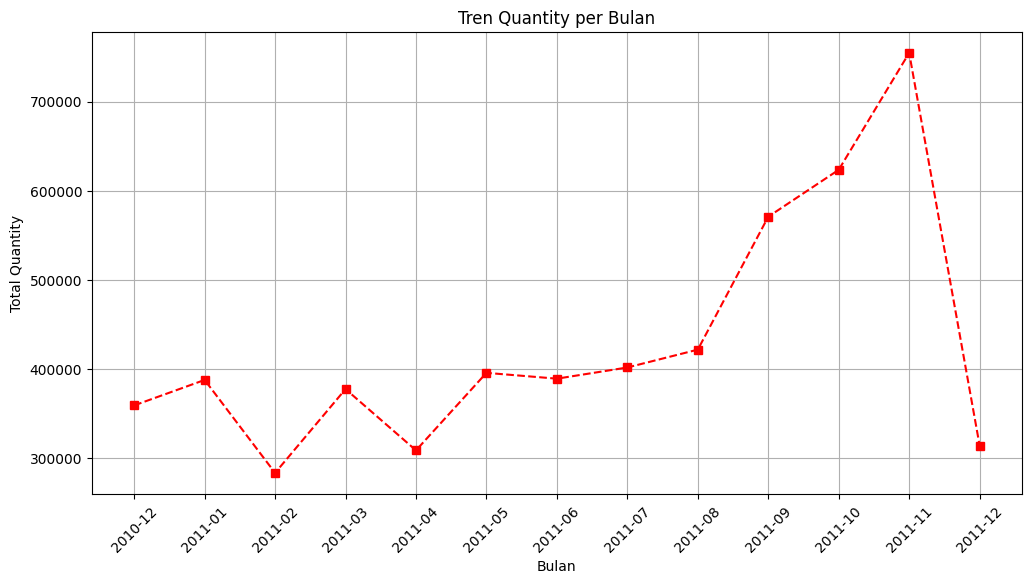

In [4]:
# Step 2: Exploratory Data Analysis (EDA)
print(df.info())
print(df.describe())

# Convert InvoiceDate ke format datetime
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'], format='%d/%m/%y %H.%M')

# Convert UnitPrice ke float (mengganti koma dengan titik)
df['UnitPrice'] = df['UnitPrice'].astype(str).str.replace(',', '.').astype(float)

# Hapus transaksi dengan Quantity atau UnitPrice negatif (biasanya retur)
df = df[(df['Quantity'] > 0) & (df['UnitPrice'] > 0)]

# Tambahkan kolom Revenue (Pendapatan per transaksi)
df['Revenue'] = df['Quantity'] * df['UnitPrice']

# Visualisasi tren Revenue per bulan
df['Month'] = df['InvoiceDate'].dt.to_period('M')
monthly_revenue = df.groupby('Month')['Revenue'].sum()
plt.figure(figsize=(12, 6))
plt.plot(monthly_revenue.index.astype(str), monthly_revenue, marker='o', linestyle='-')
plt.xticks(rotation=45)
plt.title('Tren Revenue per Bulan')
plt.xlabel('Bulan')
plt.ylabel('Total Revenue')
plt.grid()
plt.show()

# Visualisasi tren Quantity per bulan
monthly_quantity = df.groupby('Month')['Quantity'].sum()
plt.figure(figsize=(12, 6))
plt.plot(monthly_quantity.index.astype(str), monthly_quantity, marker='s', linestyle='--', color='r')
plt.xticks(rotation=45)
plt.title('Tren Quantity per Bulan')
plt.xlabel('Bulan')
plt.ylabel('Total Quantity')
plt.grid()
plt.show()


In [5]:
# Step 3: Analisis RFM (Recency, Frequency, Monetary)
latest_date = df['InvoiceDate'].max()
rfm = df.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (latest_date - x.max()).days,  # Recency
    'InvoiceNo': 'count',  # Frequency
    'Revenue': 'sum'  # Monetary
})
rfm.columns = ['Recency', 'Frequency', 'Monetary']

In [6]:
# Step 4: Standarisasi fitur
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm)

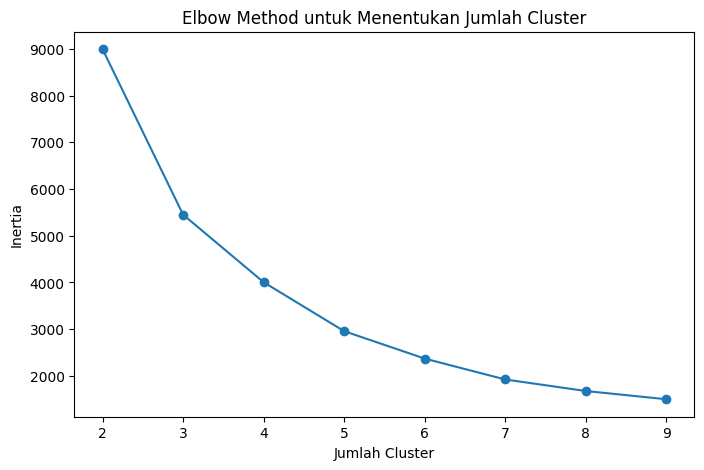

In [7]:
# Step 5: Menentukan jumlah cluster optimal (Elbow Method)
inertia = []
k_values = range(2, 10)
for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(rfm_scaled)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(8, 5))
plt.plot(k_values, inertia, marker='o')
plt.xlabel('Jumlah Cluster')
plt.ylabel('Inertia')
plt.title('Elbow Method untuk Menentukan Jumlah Cluster')
plt.show()

In [8]:
# Step 6: Clustering dengan K-Means (misal k=3 berdasarkan Elbow Method)
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
rfm['Cluster'] = kmeans.fit_predict(rfm_scaled)

In [9]:
# Step 7: Evaluasi dengan Silhouette Score
sil_score = silhouette_score(rfm_scaled, rfm['Cluster'])
print(f'Silhouette Score: {sil_score:.2f}')

Silhouette Score: 0.60


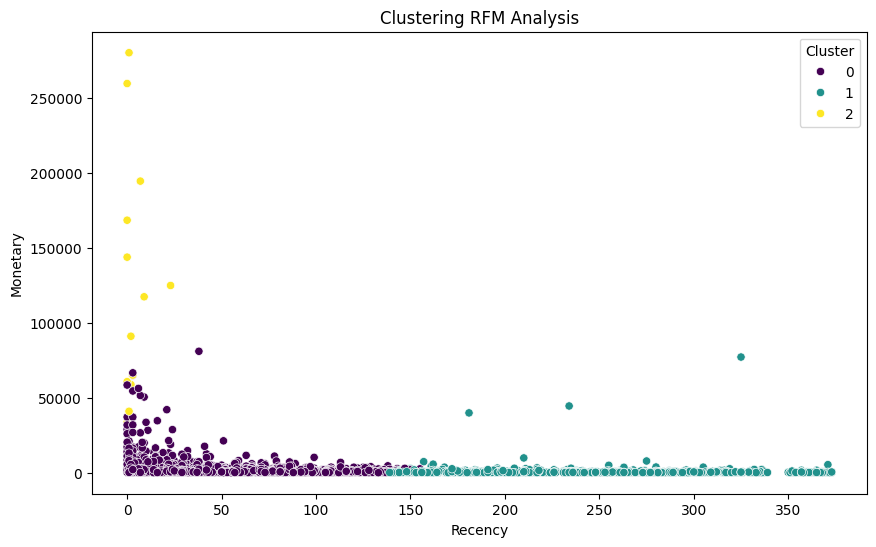

In [10]:
# Step 8: Visualisasi Cluster
plt.figure(figsize=(10, 6))
sns.scatterplot(x=rfm['Recency'], y=rfm['Monetary'], hue=rfm['Cluster'], palette='viridis')
plt.xlabel('Recency')
plt.ylabel('Monetary')
plt.title('Clustering RFM Analysis')
plt.legend(title='Cluster')
plt.show()

/var/folders/qc/5k9s4f2574xgc95xjmn9lbm40000gn/T/ipykernel_84258/2212985196.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=cluster_counts.index, y=cluster_counts.values, palette='viridis')


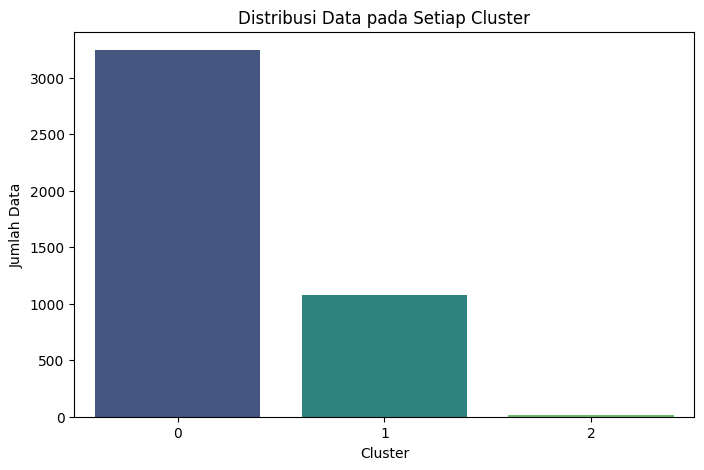

Karakteristik rata-rata per cluster:
            Recency    Frequency       Monetary
Cluster                                        
0         40.377196   103.089060    2028.833862
1        246.308333    27.787963     637.318510
2          3.692308  2565.307692  126118.310000


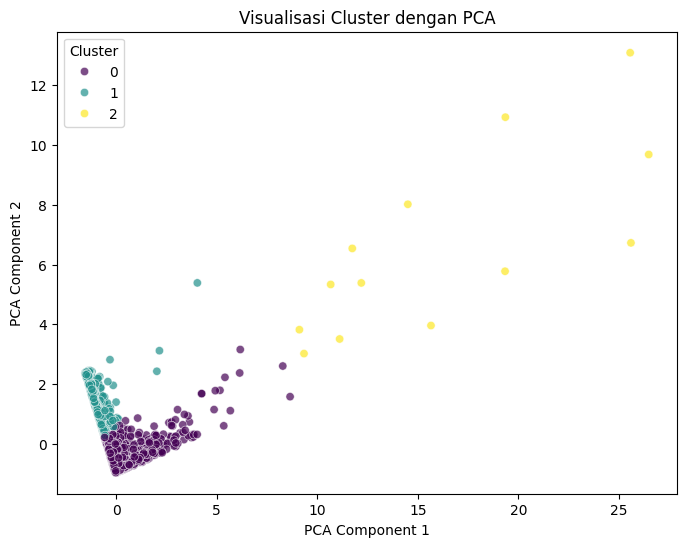

In [11]:
# 1. Melihat distribusi klaster
cluster_counts = rfm['Cluster'].value_counts()
plt.figure(figsize=(8, 5))
sns.barplot(x=cluster_counts.index, y=cluster_counts.values, palette='viridis')
plt.xlabel('Cluster')
plt.ylabel('Jumlah Data')
plt.title('Distribusi Data pada Setiap Cluster')
plt.show()

# 2. Menganalisis karakteristik setiap klaster
cluster_summary = rfm.groupby('Cluster').mean()
print("Karakteristik rata-rata per cluster:")
print(cluster_summary)

# 3. Visualisasi PCA untuk melihat sebaran klaster dalam 2D
pca = PCA(n_components=2)
rfm_pca = pca.fit_transform(rfm_scaled)
rfm['PCA1'] = rfm_pca[:, 0]
rfm['PCA2'] = rfm_pca[:, 1]

plt.figure(figsize=(8, 6))
sns.scatterplot(x='PCA1', y='PCA2', hue='Cluster', data=rfm, palette='viridis', alpha=0.7)
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('Visualisasi Cluster dengan PCA')
plt.legend(title='Cluster')
plt.show()